In [1]:
import transformers
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt

from textwrap import wrap
from transformers import BertModel, BertTokenizer, BertConfig, AdamW, get_linear_schedule_with_warmup
#from transformers.file_utils import WEIGHTS_NAME, CONFIG_NAME
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, brier_score_loss
from collections import defaultdict
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from pytorch_pretrained_bert.file_utils import WEIGHTS_NAME, CONFIG_NAME
from matplotlib import rc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

We leveraged pre-trained BERT model for this classification job. 
Since BERT and other transformers have proved effective for NLP tasks, we went with BERT.
We used APIs from Huggingface library.
Next block defines some Hpyer parameters that we experiement with. Some params are suggesstions from BERT.

In [23]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
#BATCH_SIZE = 32 #16 for better accuracy
BATCH_SIZE = 16
TEST_BATCH_SIZE = 8
EPOCHS = 4
CLASS_NAMES=['Acceptable', 'Unacceptable']
LEARNING_RATE=2e-5

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
provided_data = pd.read_csv('./data/AI_ML_Challenge_Training_Data_Set_1_v1.csv')
provided_data['words_count'] = provided_data['Clause Text'].apply(lambda x: len(x.split()))
provided_data.describe()

,Clause ID,Classification,words_count
count,7879.000000,7879.000000,7879.000000
mean,4635.594492,0.186826,79.855185
std,2676.924909,0.389796,131.183433
min,0.000000,0.000000,0.000000
25%,2330.500000,0.000000,19.000000
50%,4643.000000,0.000000,49.000000
75%,6958.500000,0.000000,101.000000
max,9269.000000,1.000000,7347.000000


Following data, which is a list of 'unacceptable' clauses is colleced from the provided 'appendix_b_unacceptable_clauses'

In [4]:
supplement_data = pd.read_csv('./data/AdditionalData.csv')
supplement_data['words_count'] = supplement_data['Clause Text'].apply(lambda x: len(x.split()))
supplement_data.describe()

,Clause ID,Classification,words_count
count,28.000000,28.0,28.000000
mean,10014.500000,1.0,16.071429
std,8.225975,0.0,20.057193
min,10001.000000,1.0,1.000000
25%,10007.750000,1.0,3.750000
50%,10014.500000,1.0,6.500000
75%,10021.250000,1.0,24.000000
max,10028.000000,1.0,91.000000


In [6]:
combined = pd.concat([provided_data, supplement_data])

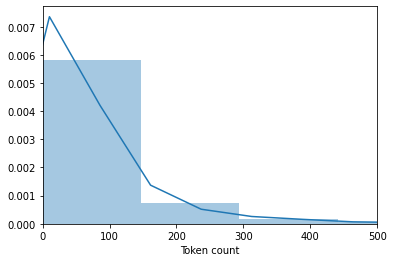

In [7]:
token_lens = []

for l in combined['words_count']:
  token_lens.append(l)

sns.distplot(token_lens)
plt.xlim([0, 500]);
plt.xlabel('Token count');

But in our case, except few outliers there was no problem with token length.
So we chose to have max length of 128 tokens.
For large text, we chunked them into smaller sentences with overlapping with pervious text to retain context.
We experiementd with smaller and larger chunks and settled on 128

In [8]:
NO_OVERLAP_SIZE = 100
MAX_LEN = 128

There was no impact on final results due to text clean up. So this is not done in final training model.
We couldn't ignore some one word sentences in the dataset. For example 'Taxes'. Since much os tax clause is unacceptable, we couldn't ignore lot of sentences that weren't well formed in the dataset.
Since we retained the case in the dataset, we used bert-base-cased

In [9]:
def cleanup_text (eula_text):
    #sentences = sent_tokenize(eula_text)
    #res = []
    #for s in sentences:
    #    s1 = re.sub("'", '', s)
    #    s1 = re.sub("(\\W)+", " ", s1)
    #    res.append(s1)
    #return ''.join(res)
    text = re.sub("'", "", eula_text)
    text=re.sub("(\\W)+", " ", eula_text)
    return text

In [10]:
def chunk_text_overlapping (text1):
  full = []
  partial = []
  if len(text1.split())//NO_OVERLAP_SIZE >0:
    n = len(text1.split())//NO_OVERLAP_SIZE
  else:
    n = 1
  for w in range(n):
    if w == 0:
      partial = text1.split()[:MAX_LEN]
      full.append(" ".join(partial))
    else:
      partial = text1.split()[w*NO_OVERLAP_SIZE:w*NO_OVERLAP_SIZE + MAX_LEN]
      full.append(" ".join(partial))
  return full

In [11]:
def prepare_data(input_df):
    data_df = []
    for index, row in input_df.iterrows():
        #cleaned_text = cleanup_text(row['Clause Text'])
        cleaned_text = row['Clause Text']
        chunks = chunk_text_overlapping(cleaned_text)
        for c in chunks:
            data_df.append({'text': c, 'label': row['Classification'] })

    df1 = pd.DataFrame(data_df, columns=['text', 'label'])
    df1['words_count'] = df1['text'].apply(lambda x: len(x.split()))
    return df1

In [12]:
df = prepare_data(combined)
print(df.shape)

(9216, 3)


In [13]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
print(df_train.shape, df_test.shape)

(8294, 3) (922, 3)


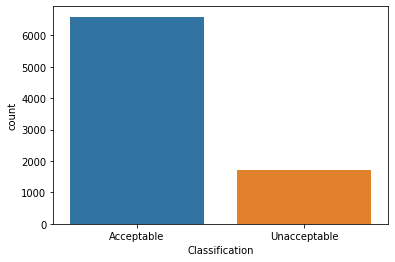

In [14]:
ax = sns.countplot(df_train['label'])
plt.xlabel('Classification')
ax.set_xticklabels(CLASS_NAMES);

Above plot shows that the dataset is skewed for one class of prediction. As shown at the last step in this notebook, creating a evenly distributed dataset by duplicating 'unacceptbale' statements didn't improve accuracy

In [15]:
class EulaDataset(Dataset):

    def __init__(self, doc, targets, tokenizer, max_len):
        self.doc = doc
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.doc)

    def __getitem__(self, item):
        doc = str(self.doc[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
                    doc,
                    add_special_tokens=True,
                    truncation=True,
                    max_length=self.max_len,
                    return_token_type_ids=False,
                    pad_to_max_length=True,
                    return_attention_mask=True,
                    return_tensors='pt',
        )

        return {
            'doc_text': doc,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

Below is our model architecture, that adds one dropout layer and one fully connected layer on top of BERT

In [16]:
class EulaClassifier(nn.Module):
    def __init__(self, n_classes):
        super(EulaClassifier, self).__init__()
        configuration = BertConfig.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, config=configuration)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [17]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = EulaDataset(
        doc=df.text.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
        )

In [18]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
    ):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [20]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["doc_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [21]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Classification')

    plt.xlabel('Predicted Classification');

Below code segment runs the training job using AdamW optimizer and get_linear_schedule_with_warmup scheduler.
With this architecture and hyperparameters we were able to get accuracy of 86%, F1-Score: 0.86 and Brier score: 0.11

In [24]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, TEST_BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, TEST_BATCH_SIZE)

data = next(iter(train_data_loader))

model = EulaClassifier(len(CLASS_NAMES))
model = model.to(device)

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), './best_model_state.bin')
        best_accuracy = val_acc


test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

print('\nTest Accuracy:\n')
print(test_acc.item())

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /root/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddi

Epoch 1/4
----------
Train loss 0.4679432944870179 accuracy 0.7884012539184954
Val   loss 0.4059918661569727 accuracy 0.8347826086956522

Epoch 2/4
----------
Train loss 0.3842952110892546 accuracy 0.8222811671087533
Val   loss 0.3640841407508686 accuracy 0.8565217391304348

Epoch 3/4
----------
Train loss 0.3182332269732548 accuracy 0.8624306727755003
Val   loss 0.35330478949793453 accuracy 0.8608695652173913

Epoch 4/4
----------
Train loss 0.26085172987656097 accuracy 0.89100554617796
Val   loss 0.3764506370343011 accuracy 0.8739130434782609


Test Accuracy:

0.8614718614718615
              precision    recall  f1-score   support

  Acceptable       0.91      0.93      0.92       195
Unacceptable       0.57      0.47      0.52        36

    accuracy                           0.86       231
   macro avg       0.74      0.70      0.72       231
weighted avg       0.85      0.86      0.86       231



In [25]:
predictions_0 = [p[0].item() for p in y_pred_probs ]
y = [y.item() for y in y_test]
avg_brier = brier_score_loss(y, predictions_0, pos_label=0)
print('P(class=0): Brier Score=%.4f' % (avg_brier))

P(class=0): Brier Score=0.1190


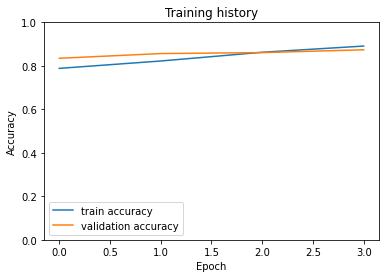

In [26]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


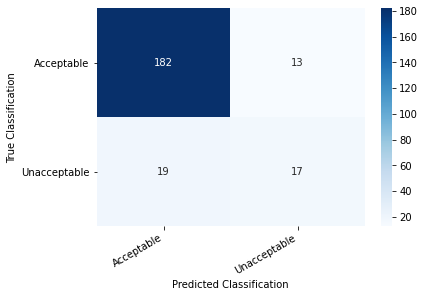

In [27]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
show_confusion_matrix(df_cm)